# Taylor method example: $\dot x=x^2$

Here, we will Taylor-integrate the IVP defined by

$$
\begin{align}
\dot x &= x^2 \\
x(0)&=x_0
\end{align}
$$

The analytical solution is:

$$
x(t)=\frac{1}{\frac{1}{x_0}-t}
$$

In particular, the analytical solution exhibits a divergence at $t=1/x_0$. How does the numerical solution behave near this divergence? We will make two attempts: constant time-step Taylor integration, and then variable time-step Taylor method.

We start off by including the relevant packages:

In [1]:
using TaylorSeries
using TaylorIntegration
using FastAnonymous
using PyPlot

The ODE:

In [2]:
function eqs_mov{T<:Number}(x::Array{Taylor1{T}}, params)
    [(x[1]^2)::Taylor1{T}]
end

eqs_mov (generic function with 1 method)

A `FastAnonymous` version of the ODE:

In [3]:
f_anon = @anon (x__, params__) -> eqs_mov(x__, params__)

(x__,params__) -> quote  # In[3], line 1:
    Main.eqs_mov(x__,params__)
end

In [4]:
methods(f_anon)

1-element Array{Any,1}:
 call{ast_p,ast_hash,argnames}(f::FastAnonymous.Fun{ast_p,ast_hash,argnames}, __X__...) at /Users/Jorge/.julia/v0.4/FastAnonymous/src/FastAnonymous.jl:32

## 1. Constant time-step Taylor

We select $x_0=3$, $t_0=0$. Then, the singularity is at $t=1/3$. The order of the integration is $28$, and the time step is $0.001$.

In [5]:
const q0=[3.0] # initial condition
println("q0=", q0)
const order=28
const t0 = 0.0
const T=1.0
const time_step = 0.001

q0=[3.0]


0.001

The `FastAnonymous` version of the time step size control method (in this case, constant time step) is:

In [6]:
constep_anon = @anon (q, epsilon) -> epsilon

(q,epsilon) -> quote  # In[6], line 1:
    epsilon
end

This array of arrays is store the $t$ and $x$ values at each time step:

In [7]:
q = Array{Float64,1}[]

t = Float64[]; push!(q, t)
x = Float64[]; push!(q, x)

2-element Array{Array{Float64,1},1}:
 Float64[]
 Float64[]

Now, we are ready to perform the Taylor integration:

In [8]:
#@code_warntype taylor_integrator!(f_anon, constep_anon, q0, time_step, order, t0, T, q)

In [9]:
@time integrate!(f_anon, constep_anon, q0, time_step, order, t0, T, q)

  0.215838 seconds (452.93 k allocations: 27.985 MB, 2.22% gc time)


1-element Array{Float64,1}:
 Inf

In [10]:
#@time taylor_integrator!(f_anon, constep_anon, q0, time_step, order, T, q)

Plot $x$ vs $t$:

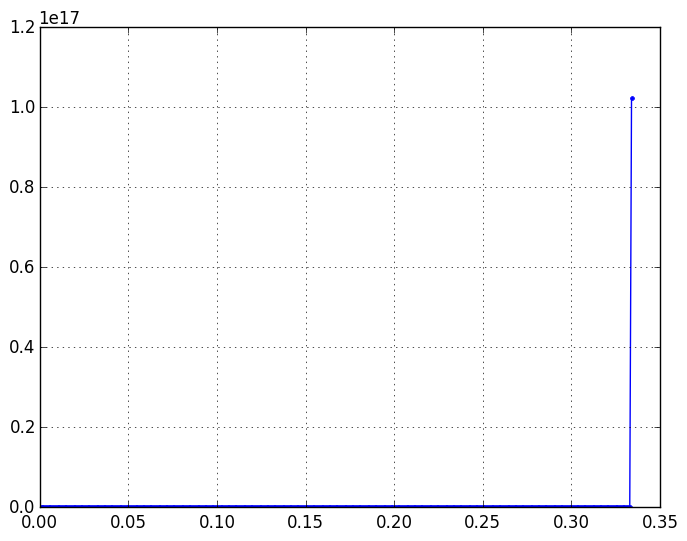

In [10]:
# axis([0, 0.35, -15, 10])
grid(true)
plot(t, x, ".-");

What is the final state of the system?

In [11]:
t[end], x[end]

(1.0000000000000007,Inf)

How does the numerical solution compare to the analytical solution? The analytical solution is:

In [12]:
xs(t, x0) = 1./((1./x0).-t) #analytical solution

xs (generic function with 1 method)

The relative difference between the numerical and analytical solution, $\delta x$, is:

In [13]:
δx = (x.-xs(t, q0[1]))./xs(t, q0[1]);

The $\delta x$ vs $t$ plot (logscale):

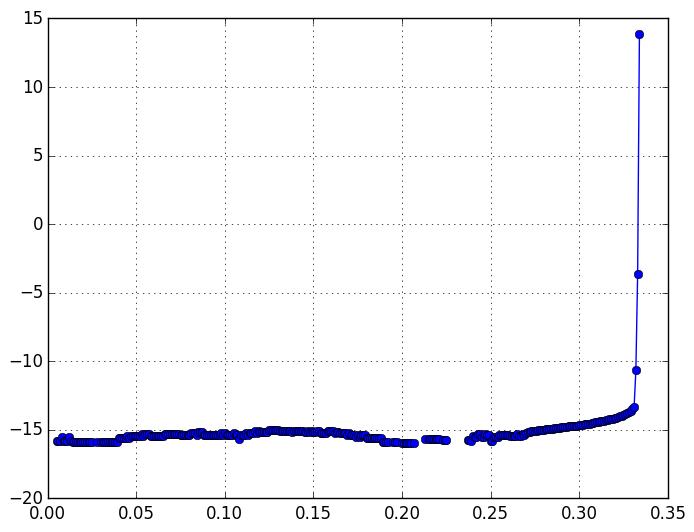

In [14]:
grid(true)
plot(t, log10(abs(δx)), "o-");

At the end of the integration, the numerical and analytical solutions differ by about $10^{15}$ times the value of the anaylitical solution!!! And that's even before diverging to `Inf`!!! Constant time-step Taylor integration breaks down in this case (as any constant time-step integrator would break down trying to get past the $t=1/3$ singularity).

## 2. Variable time-step Taylor

Again, we select $x_0=3$, $t_0=0$. The order of the integration is $28$, and now the absolute tolerance is $10^{-20}$. We use a underscore posfix where needed to avoid overwriting the variables of the first section.

In [15]:
const q0_=[3.0] # initial condition
println("q0_=", q0_)
const order_=28
const t0_ = 0.0
const T_=1.0
const abs_tol = 1.0E-20

q0_=[3.0]


1.0e-20

The `FastAnonymous` version of time step control method is:

In [16]:
stepsizeall_anon = @anon (q, epsilon) -> stepsizeall(q, epsilon)

(q,epsilon) -> quote  # In[16], line 1:
    Main.stepsizeall(q,epsilon)
end

This array of arrays stores the $t$ and $x$ values at each time step:

In [17]:
q_ = Array{Float64,1}[]

t_ = Float64[]; push!(q_, t_)
x_ = Float64[]; push!(q_, x_)

2-element Array{Array{Float64,1},1}:
 Float64[]
 Float64[]

We need a Taylor integrator which can stop the integration after a user-defined number of time steps:

Uncomment the line below only if you want to test type stability for `taylor_integrator_k`:

In [18]:
# @code_warntype taylor_integrator_k(f_anon, stepsizeall_anon, q0_, abs_tol, order_, T_, q_, 500)

In [19]:
@time integrate_k!(f_anon, stepsizeall_anon, q0_, abs_tol, order_, t0_, T_, q_, 500)

number of steps=500
  0.083303 seconds (186.48 k allocations: 12.338 MB, 6.13% gc time)


1-element Array{Float64,1}:
 2.95623e10

__21 aug 2016: I tested `@noinline`-d version of `integrate_k!`, with the `@noinline` macro outside the integrator function declaration. There is not a clear improvement by using `@noinline` ... Is it better if the `@noinline` macro is used "deeper" into the code, for smaller functions which get called a lot?__ Since @noinline replaces the calling of a function by its body during compilation, my guess is perhaps yes... __ Needs further study!  __

On the other hand, `@inbounds` does seem to improve things a little bit

In [20]:
t_[end], x_[end]

(0.3333333332995065,2.95622790901489e10)

$x$ vs $t$ plot:

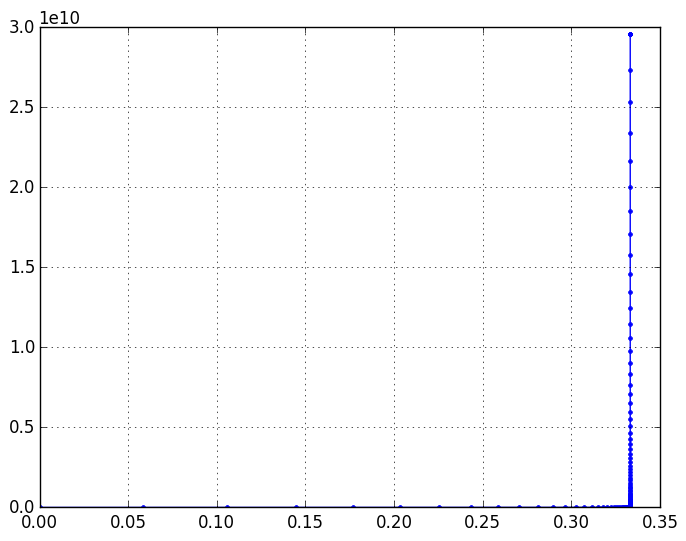

In [21]:
# axis([0, 0.35, -15, 10])
grid(true)
plot(t_, x_, ".-");

Does the integrator get past the singularity?

In [22]:
t_[end] < 1/3

true

The answer is no!

Now, the relative difference between the numerical and analytical solution, $\delta x$, is:

In [23]:
δx_ = (x_.-xs(t_, q0[1]))./xs(t_, q0_[1]);

The $\delta x$ vs $t$ plot (logscale):

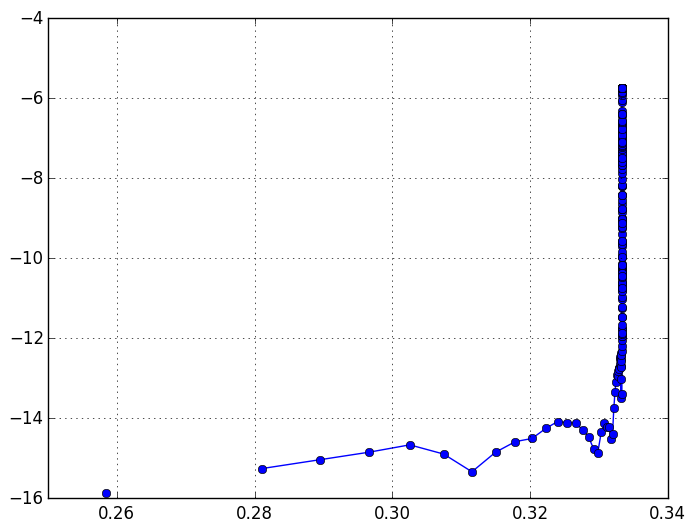

In [24]:
grid(true)
plot(t_, log10(abs(δx_)), "o-");

In [25]:
eps(prevfloat(Inf))

1.99584030953472e292

After 500 steps, the numerical and analytical solution differ by less than about $10^{-5}$ times the value of the analytical solution; that's a $ \sim 10^{20}$ improvement over the constant time-step integration!!!! Moreover, the variable time-step Taylor integrator approaches asymptotically to the time value $t=1/3$ without diverging.

Lastly, what happens actually to the time step?

Below, we plot the time-step as a function of the number of iterations:

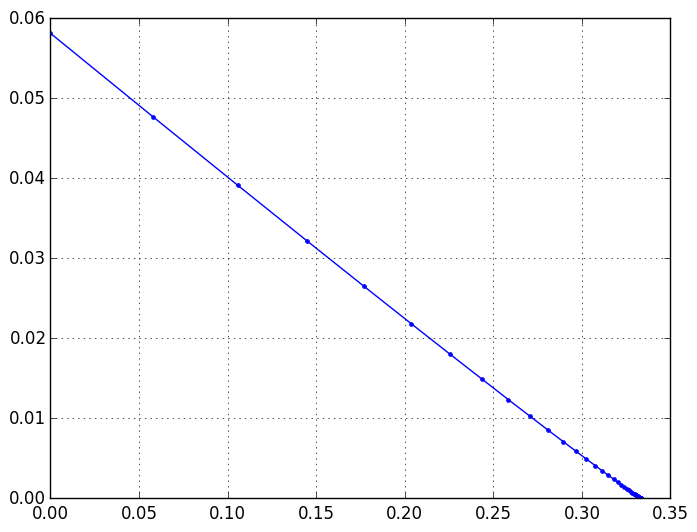

In [26]:
grid(true)
plot(t_[1:end-1], diff(t_), ".-");

A zoom around $t=1/3$:

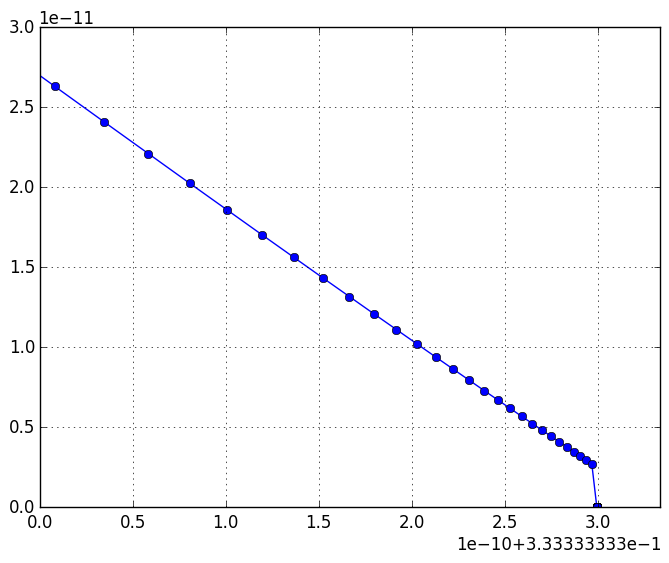

In [27]:
axis([0.333333333, 1.0/3.0, 0.0, 0.00000000003])
grid(true)
plot(t_[1:end-1], diff(t_), "o-");